In [1]:
#Import all the required packages
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from math import pi
from sklearn.model_selection import train_test_split

from metrics import metrics

In [7]:
modelName = "gitCorrection1"
ptMin=100
ptMax=120

#Load data
dataInitial = np.load("gitJetData.npy").T
for x in [0,3,12,15]:
    dataInitial[x] = np.log(tf.math.maximum(dataInitial[x],0.01))

#Normalize data
normInfoIn=[[0,1],[0,1],[0,1],[0,1]]
normInfoOut=[[0,1],[0,1],[0,1],[0,1]]

#normalization
for x in [0,1,3]:
    normInfoIn[x][0]=np.mean(dataInitial[x])
    normInfoIn[x][1]=np.std(dataInitial[x])
    
    normInfoOut[x][0]=np.mean(dataInitial[x+12])
    normInfoOut[x][1]=np.std(dataInitial[x+12])
    if(x!=1):
        dataInitial[x+12] = np.exp(dataInitial[x+12])
data=dataInitial
algorithm = data[0:4,:].T
rawRecoData = data[4:8,:].T
genData = data[12:16,:].T
correctedRecoData = data[8:12,:].T
inputData=algorithm

newInput=[]
newRaw=[]
newReco=[]
newGen=[]


#Select data
for x in range(len(inputData)):
    #if(np.exp(inputData[x,0])<ptMax and np.exp(inputData[x,0])>ptMin):
    #Uncorrected alg delta
    
    #if(rawRecoData[x,0]<ptMax and rawRecoData[x,0]>ptMin):
    #Raw reco delta
    
    #if(genData[x,0]<ptMax and genData[x,0]>ptMin):
    #Gen delta
    
    if(True):
        #All
        newInput.append(inputData[x,:])
        newRaw.append(rawRecoData[x,:])
        newReco.append(correctedRecoData[x,:])
        newGen.append(genData[x,:])

inputData = np.array(newInput).T
rawRecoData = np.array(newRaw).T
correctedRecoData = np.array(newReco).T
genData = np.array(newGen).T

for x in range(4):
    inputData[x,:] = (inputData[x,:]-normInfoIn[x][0])/normInfoIn[x][1]

#Metrics
metricObject = metrics(1, 0, 1, 0, 1, 0)

#Load model
model = tf.keras.models.load_model(modelName, compile=False,custom_objects={"custom_loss": metrics.custom_loss,"pt_error":metricObject.pt_error, "eta_error":metricObject.eta_error, "phi_error":metricObject.phi_error, "e_error":metricObject.e_error, "dPT":metricObject.dPT, "dR":metricObject.dR})
model.compile(optimizer=tf.keras.optimizers.Adam(0.01,
                  amsgrad=True),loss=tf.keras.losses.MeanSquaredError(),
                  metrics=["mae", "mse"])  
#Make prediction
algCorrected = np.array(model.predict(inputData.T)).T

#Unnormalize data
for x in [0,3]:
    algCorrected[x,:] = np.exp(normInfoOut[x][1]*algCorrected[x,:]+normInfoOut[x][0])
    inputData[x,:] = np.exp(normInfoIn[x][1]*inputData[x,:]+normInfoIn[x][0])
    
for x in [1,2]:
    algCorrected[x,:] = normInfoOut[x][1]*algCorrected[x,:]+normInfoOut[x][0]
    inputData[x,:] = normInfoIn[x][1]*inputData[x,:]+normInfoIn[x][0]
algCorrected[2,:] = np.where(algCorrected[2,:]>pi, algCorrected[2,:]-2*pi, algCorrected[2,:])
algCorrected[2,:] = np.where(algCorrected[2,:]<-pi, algCorrected[2,:]+2*pi, algCorrected[2,:])

(4, 209083)


In [8]:

#calculations
ptRawReco = rawRecoData[0]
ptGen = genData[0]
ptReco = correctedRecoData[0]
ptAlg = inputData[0]
ptAlgCorrected = algCorrected[0]

etaRawReco = rawRecoData[1]
etaGen = genData[1]
etaReco = correctedRecoData[1]
etaAlg = inputData[1]
etaAlgCorrected = algCorrected[1]

phiRawReco = rawRecoData[2]%(2*pi)
phiGen = genData[2]%(2*pi)
phiReco = correctedRecoData[2]%(2*pi)
phiAlg = inputData[2]%(2*pi)
phiAlgCorrected = algCorrected[2]%(2*pi)



dPhi2Alg = np.minimum(np.square(phiGen-phiAlg), np.square(phiAlg-phiGen))
dPhi2AlgCorrected = np.minimum(np.square(phiGen-phiAlgCorrected), np.square(phiAlgCorrected-phiGen))
dPhi2Reco = np.minimum(np.square(phiGen-phiReco), np.square(phiReco-phiGen))
dPhi2Raw = np.minimum(np.square(phiGen-phiRawReco), np.square(phiRawReco-phiGen))


dEta2Alg = np.square(etaGen-etaAlg)
dEta2AlgCorrected = np.square(etaGen-etaAlgCorrected)
dEta2Reco = np.square(etaGen-etaReco)
dEta2Raw = np.square(etaGen-etaRawReco)

dR2Alg = dEta2Alg+dPhi2Alg
dR2AlgCorrected = dEta2AlgCorrected+dPhi2AlgCorrected
dR2Reco = dEta2Reco+dPhi2Reco
dR2Raw = dEta2Raw+dPhi2Raw


ptRatioAlg = np.abs(ptAlg)/ptGen
ptRatioAlgCorrected = np.abs(ptAlgCorrected)/ptGen
ptRatioReco = np.abs(ptReco)/ptGen
ptRatioRaw = np.abs(ptRawReco)/ptGen

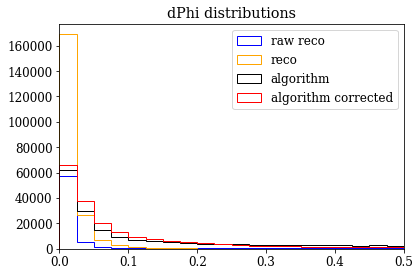

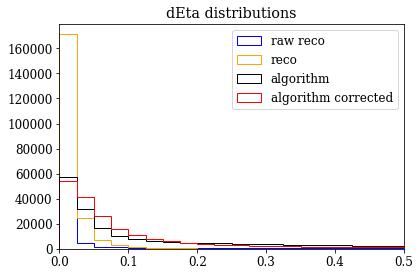

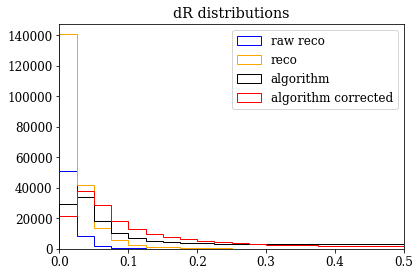

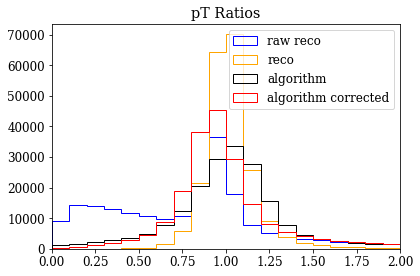

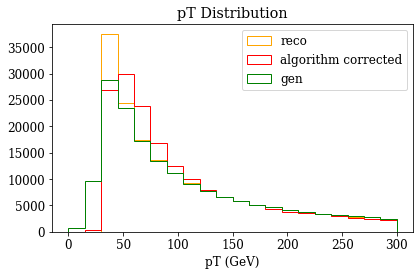

In [11]:
font = {'family' : 'serif',
        'size'   : 12}

matplotlib.rc('font', **font)


bins=20

#Make some graphs

plt.figure(figsize=(6,4))
plt.hist(np.sqrt(dPhi2Raw), range=(0,0.5), bins=bins, label="raw reco", histtype="step", color="b")
plt.hist(np.sqrt(dPhi2Reco), range=(0,0.5), bins=bins, label="reco", histtype="step", color="orange")
plt.hist(np.sqrt(dPhi2Alg), range=(0,0.5), bins=bins, label="algorithm", histtype="step", color="k")
plt.hist(np.sqrt(dPhi2AlgCorrected), range=(0,0.5), bins=bins, label="algorithm corrected", histtype="step", color="r")

plt.legend()
plt.title("dPhi distributions")
plt.xlim(0,0.5)
plt.tight_layout()
plt.show()


plt.figure(figsize=(6,4))
plt.hist(np.sqrt(dEta2Raw), range=(0,0.5), bins=bins, label="raw reco", histtype="step", color="b")
plt.hist(np.sqrt(dEta2Reco), range=(0,0.5), bins=bins, label="reco", histtype="step", color="orange")
plt.hist(np.sqrt(dEta2Alg), range=(0,0.5), bins=bins, label="algorithm", histtype="step", color="k")
plt.hist(np.sqrt(dEta2AlgCorrected), range=(0,0.5), bins=bins, label="algorithm corrected", histtype="step", color="r")

plt.legend()
plt.title("dEta distributions")
plt.xlim(0,0.5)
plt.tight_layout()
plt.show()



plt.figure(figsize=(6,4))
plt.hist(np.sqrt(dR2Raw), range=(0,0.5), bins=bins, label="raw reco", histtype="step", color="b")
plt.hist(np.sqrt(dR2Reco), range=(0,0.5), bins=bins, label="reco", histtype="step", color="orange")
plt.hist(np.sqrt(dR2Alg), range=(0,0.5), bins=bins, label="algorithm", histtype="step", color="k")
plt.hist(np.sqrt(dR2AlgCorrected), range=(0,0.5), bins=bins, label="algorithm corrected", histtype="step", color="r")

plt.legend()
plt.title("dR distributions")
plt.xlim(0,0.5)
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(ptRatioRaw, range=(0,2), bins=bins, label="raw reco", histtype="step", color="b")
plt.hist(ptRatioReco, range=(0,2), bins=bins, label="reco", histtype="step", color="orange")
plt.hist(ptRatioAlg, range=(0,2), bins=bins, label="algorithm", histtype="step", color="k")
plt.hist(ptRatioAlgCorrected, range=(0,2), bins=bins, label="algorithm corrected", histtype="step", color="r")

plt.legend()#loc='upper right')
plt.title("pT Ratios")
plt.xlim(0,2)

plt.tight_layout()
plt.show()



plt.figure()
plt.hist(ptReco, range=(0,300), bins=bins, label="reco", histtype="step", color="orange")
plt.hist(ptAlgCorrected, range=(0,300), bins=bins, label="algorithm corrected", histtype="step", color="r")
plt.hist(ptGen, range=(0,300), bins=bins, label="gen", histtype="step", color="g")

plt.xlabel("pT (GeV)")
plt.legend()
plt.title("pT Distribution")
plt.tight_layout()
plt.show()